In [1]:
#importing necessary packages
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from scipy import stats
import calendar

In [2]:
#importing data from Picarro
df = pd.read_csv('PS1data.csv')
df

,time_local,hcho_ppb,temp_k,pres_torr
0,04-Jul-2022 00:02:10,1.074500,296.35,740.634909
1,04-Jul-2022 00:07:10,1.055055,296.35,740.671728
2,04-Jul-2022 00:12:10,0.872645,296.35,740.703591
3,04-Jul-2022 00:17:10,0.661606,296.27,740.670263
4,04-Jul-2022 00:22:10,0.696630,296.19,740.678217
...,...,...,...,...
283,04-Jul-2022 23:37:10,1.827965,296.29,741.836824
284,04-Jul-2022 23:42:10,1.854989,296.35,741.942153
285,04-Jul-2022 23:47:10,NaN,296.35,741.914547
286,04-Jul-2022 23:52:10,1.852875,296.29,741.797304


We want to check if total mass collected from 4:00 to 12:00 = 1.86 μg ± 20% and if mass from 12:00 to 20:00 = 5.38 μg ± 20%. First let's isolate the data from each of those time periods.

In [3]:
#assigning start, middle, and end times – datetime(year, month, day, hour, minute, second)
start = dt.datetime(2022,7,4,4,0,0)
middle = dt.datetime(2022,7,4,12,0,0)
end = dt.datetime(2022,7,4,20,0,0)

#quick for loop to go thru data and find endpoints of time periods to slice dataframe
format_data = '%H:%M:%S' #we just want the time from the string, so we'll slice the string to only include time
i = 0

#function to convert string of date&time to a datetime datatype
def string_to_time(row):
    t = dt.datetime.strptime(df.iloc[i][0][-8:],format_data).time() #gathering time from string
    date_time = dt.datetime.combine(dt.date(2022, 7, 4), t) #assigning known date to time
    return date_time

#loop through whole dataset to find first datapoint after 4:00
for i in range(len(df)): 
    date_time = string_to_time(i) #get date&time for given row
    if date_time>=start: #if time is after 4:00, print row number and beginning
        print('first after 4:00 – '+str(i))
        break #we break out of loop now that we know which row to start at


#we know now that row 48 is the first datapoint after 4:00, so iterate after that
#same procedure as above
i=0
for i in range(48,len(df)):
    date_time = string_to_time(i)
    if date_time >= middle:
        print('first after 12:00 – '+str(i))
        break


#we know now that row 144 is the first datapoint after 12:00, so iterate after that
#same procedure as above
for i in range(144,len(df)):
    date_time = string_to_time(i)
    if date_time >= end:
        print('last before 20:00 - '+str(i-1))
        break


first after 4:00 – 48
first after 12:00 – 144
last before 20:00 - 239


Now we know that  4:00-12:00 represents rows 48-143 (inclusive) and 12:00-20:00 represents rows 144-238 (inclusive). Now let's slice the dataframe to get 4 df's of before 4:00, 4:00-12:00, 12:00-20:00, and after 20:00.

In [4]:
#slicing the original dataframe into the two smaller df's using the boundaries found above

df_4_12 = df.iloc[48:144] #cut a df 4:00-12:00
df_12_20 = df.iloc[144:240] #cut a df 12:00-20:00

#now we check that the df's we need to use are correctly sliced (they are)
print(df_4_12)
print(df_12_20)

               time_local  hcho_ppb  temp_k   pres_torr
48   04-Jul-2022 04:02:10  0.775358  296.49  740.371512
49   04-Jul-2022 04:07:10  0.613576  296.45  740.359048
50   04-Jul-2022 04:12:10  0.542099  296.49  740.446340
51   04-Jul-2022 04:17:10  0.776271  296.55  740.476006
52   04-Jul-2022 04:22:10  0.608721  296.53  740.490163
..                    ...       ...     ...         ...
139  04-Jul-2022 11:37:10  7.106167  305.39  741.787038
140  04-Jul-2022 11:42:10  7.087681  304.83  741.711775
141  04-Jul-2022 11:47:10       NaN  304.17  741.648209
142  04-Jul-2022 11:52:10  7.011607  305.85  741.600048
143  04-Jul-2022 11:57:10  7.598671  306.77  741.618486

[96 rows x 4 columns]
               time_local  hcho_ppb  temp_k   pres_torr
144  04-Jul-2022 12:02:10  7.731239  307.25  741.613347
145  04-Jul-2022 12:07:10  7.670703  307.53  741.522874
146  04-Jul-2022 12:12:10  7.704528  307.35  741.585685
147  04-Jul-2022 12:17:10  7.547832  307.01  741.522130
148  04-Jul-2022 12:22:10

With the smaller df's, we'll calculate the mass of formaldehyde measured by Picarro over the 4:00-12:00 period and the 12:00-20:00 period. To do this, we'll first calculate the density of air from the given P and T data. 

In [5]:
#density = n/V = P/(RT)
R = 62.36 #L*torr/(mol*K)
#write a function to calculate density
def density(P,T):
    return P/(R*T) #(mol/L)

#iterate over the 4-12 period for density in that time
#store values in df A, where columns are times, densities in mol/L, and CH2O concentraiton in ppb
dfA = pd.DataFrame(columns = ['Time','Air Density', 'CH2O (ppb)'], index=range(len(df_4_12)))
for i in range(len(df_4_12)):
    P = df_4_12.iloc[i][3] #glean pressure data
    T = df_4_12.iloc[i][2] #glean temperature data
    conc = df_4_12.iloc[i][1] #glean concentration data
    time = string_to_time(df_4_12.iloc[i][0]) + dt.timedelta(hours=4) #glean time data and make corrections
    d = density(P,T) #calculate density from P and T
    dfA.loc[i] = [time,d,conc] #append time, density, and concentration to the new dataframe
print(dfA)

#now iterate over the 12:00-20:00 period for density in that time
#exact same procedure as above
dfB = pd.DataFrame(columns = ['Time','Air Density','CH2O (ppb)'], index=range(len(df_12_20)))
for i in range(len(df_12_20)):
    P = df_12_20.iloc[i][3]
    T = df_12_20.iloc[i][2]
    conc = df_12_20.iloc[i][1]
    time = string_to_time(df_12_20.iloc[i][0]) + dt.timedelta(hours=12)
    d = density(P,T)
    dfB.loc[i]=[time,d,conc]
print(dfB)


                   Time Air Density CH2O (ppb)
0   2022-07-04 04:02:10    0.040044   0.775358
1   2022-07-04 04:07:10    0.040048   0.613576
2   2022-07-04 04:12:10    0.040048   0.542099
3   2022-07-04 04:17:10    0.040041   0.776271
4   2022-07-04 04:22:10    0.040045   0.608721
..                  ...         ...        ...
91  2022-07-04 11:37:10    0.038951   7.106167
92  2022-07-04 11:42:10    0.039019   7.087681
93  2022-07-04 11:47:10      0.0391        NaN
94  2022-07-04 11:52:10    0.038883   7.011607
95  2022-07-04 11:57:10    0.038767   7.598671

[96 rows x 3 columns]
                   Time Air Density CH2O (ppb)
0   2022-07-04 12:02:10    0.038706   7.731239
1   2022-07-04 12:07:10    0.038666   7.670703
2   2022-07-04 12:12:10    0.038692   7.704528
3   2022-07-04 12:17:10    0.038732   7.547832
4   2022-07-04 12:22:10    0.038774   8.148717
..                  ...         ...        ...
91  2022-07-04 19:37:10    0.039631   7.912019
92  2022-07-04 19:42:10    0.039893  

We have time series for air density in mol/L. Now, we multiply each density value (1 L/min taken at 5 minute intervals, so 5 L are collected) by 5 L to find the moles of air measured during that interval, and then multiply that product by the mole fraction of formaldehyde in the air to find the moles of formaldehyde measured. Then we will multiply each datapoint of moles of formaldehyde by the molar mass of formaldehyde, then convert to micrograms, and finally add up each datapoint in both time windows to find the total amount of formaldehyde measured during each period.

In [6]:
#define a function to convert timestamps to number for linear interpolation
def toTimestamp(d):
    return calendar.timegm(d.timetuple())
# Define a function to execute these computations
def mol_form_calc(dens, conc):
    # Convert concentration from ppb to standard mole fraction units
    frac = conc * 10**-9 #multiply by 10^-9 because we start at ppb
    mol_air = dens * 5 #5 min of 1 L/min air drawing x mol/L air = 5*x mol air
    mol_form = frac * mol_air #mol CH2O = mole fraction * number of moles of air
    return mol_form

# Define the molar mass of formaldehyde
M = 30.031  # (g/mol)

# Run calculations for the 4:00-12:00 window
dfA_mass_form = pd.DataFrame(columns=['Time', 'Mass CH2O (μg)'], index=range(len(dfA)))
for i in range(len(dfA)):
    # Don't perform calculations on NaN concentration, as that will raise an error
    time = dfA.iloc[i][0] #glean time data
    dens = dfA.iloc[i][1] #glean density data
    if np.isnan(dfA.iloc[i][2]) == False:
        conc = dfA.iloc[i][2] #glean concentration data
        moles = mol_form_calc(dens, conc) #calculate moles of CH2O from the density of air and CH2O concentration
        # Finding mass of formaldehyde and converting to micrograms
        mass = moles * M * 10**6 #multiply moles of CH2O by molar mass and 10^6 to get into μg
        dfA_mass_form.loc[i] = [time, mass] #append time and CH2O mass to new dataframe
    else: #if concentration is NaN, linearly interpolate conc and then do perform calculations
        time = dfA.iloc[i][0] #glean time data
        #check if conc of row above this one is NaN, if not use that as first interpolation anchor point
        if np.isnan(dfA.iloc[i-1][2]) == False: 
            #gather time and conc data for first anchor point
            conc_last = dfA.iloc[i-1][2] 
            time_last = toTimestamp(dfA.iloc[i-1][0])
            #check if conc of row below this one is NaN, if not use that as second interpolation anchor point
            if np.isnan(dfA.iloc[i+1][2]) == False: 
                #gather current time plus time and conc data for second anchor point 
                conc_next = dfA.iloc[i+1][2]
                time_next = toTimestamp(dfA.iloc[i+1][0])
                time_now = toTimestamp(time)
                #assemble array of first and last time anchors, then first and last conc anchors
                arr1 = np.array([time_last,time_next])
                arr2 = np.array([conc_last,conc_next])
                #interpolate using current time and given anchor points to estimate current conc
                conc = np.interp(time_now,arr1,arr2)
                #calculate moles of CH2O and use that to find mass of CH2O in μg
                moles = mol_form_calc(dens, conc)
                mass = moles * M * 10**6
                #append current time and estimated mass to new dataframe
                dfA_mass_form.loc[i] = [time,mass]
            else: #if next row down has NaN conc, use row after that
                conc_next = dfA.iloc[i+2][2]
                time_next = toTimestamp(dfA.iloc[i+2][0])
                time_now = toTimestamp(time)
                arr1 = np.array([time_last,time_next])
                arr2 = np.array([conc_last,conc_next])
                conc = np.interp(time_now,arr1,arr2)
                moles = mol_form_calc(dens, conc)
                mass = moles * M * 10**6
                dfA_mass_form.loc[i] = [time,mass]
        else: #if next row up has NaN conc, use row before that
            conc_last = dfA.iloc[i-2][2]
            time_last = toTimestamp(dfA.iloc[i-2][0])
            if np.isnan(dfA.iloc[i+1][2]) == False:
                conc_next = dfA.iloc[i+1][2]
                time_next = toTimestamp(dfA.iloc[i+1][0])
                time_now = toTimestamp(time)
                arr1 = np.array([time_last,time_next])
                arr2 = np.array([conc_last,conc_next])
                conc = np.interp(time_now,arr1,arr2)
                moles = mol_form_calc(dens, conc)
                mass = moles * M * 10**6
                dfA_mass_form.loc[i] = [time,mass]
            else:
                conc_next = dfA.iloc[i+2][2]
                time_next = toTimestamp(dfA.iloc[i+2][0])
                time_now = toTimestamp(time)
                arr1 = np.array([time_last,time_next])
                arr2 = np.array([conc_last,conc_next])
                conc = np.interp(time_now,arr1,arr2)
                moles = mol_form_calc(dens, conc)
                mass = moles * M * 10**6
                dfA_mass_form.loc[i] = [time,mass]
                
# Now do the same thing for the 12:00-20:00 period (same procedure)
dfB_mass_form = pd.DataFrame(columns=['Time', 'Mass CH2O (μg)'], index=range(len(dfB)))
for i in range(len(dfB)):
    # Don't perform calculations on NaN, as that will raise an error
    if np.isnan(dfB.iloc[i][2]) == False:
        dens = dfB.iloc[i][1]
        conc = dfB.iloc[i][2]
        time = dfB.iloc[i][0]
        moles = mol_form_calc(dens, conc)
        # Finding mass of formaldehyde and converting to micrograms
        mass = moles * M * 10**6 #moles * molar mass * 10^6 μg/g to get μg CH2O
        dfB_mass_form.loc[i] = [time, mass]
    else: #if concentration is NaN, linearly interpolate conc and then do perform calculations (exact same as above)
        time = dfB.iloc[i][0] #glean time data
        if np.isnan(dfB.iloc[i-1][2]) == False:
            conc_last = dfB.iloc[i-1][2]
            time_last = toTimestamp(dfB.iloc[i-1][0])
            if np.isnan(dfB.iloc[i+1][2]) == False:
                conc_next = dfB.iloc[i+1][2]
                time_next = toTimestamp(dfB.iloc[i+1][0])
                time_now = toTimestamp(time)
                arr1 = np.array([time_last,time_next])
                arr2 = np.array([conc_last,conc_next])
                conc = np.interp(time_now,arr1,arr2)
                moles = mol_form_calc(dens, conc)
                mass = moles * M * 10**6
                dfB_mass_form.loc[i] = [time,mass]
            else:
                conc_next = dfB.iloc[i+2][2]
                time_next = toTimestamp(dfB.iloc[i+2][0])
                time_now = toTimestamp(time)
                arr1 = np.array([time_last,time_next])
                arr2 = np.array([conc_last,conc_next])
                conc = np.interp(time_now,arr1,arr2)
                moles = mol_form_calc(dens, conc)
                mass = moles * M * 10**6
                dfB_mass_form.loc[i] = [time,mass]
        else:
            conc_last = dfB.iloc[i-2][2]
            time_last = toTimestamp(dfB.iloc[i-2][0])
            if np.isnan(dfB.iloc[i+1][2]) == False:
                conc_next = dfB.iloc[i+1][2]
                time_next = toTimestamp(dfB.iloc[i+1][0])
                time_now = toTimestamp(time)
                arr1 = np.array([time_last,time_next])
                arr2 = np.array([conc_last,conc_next])
                conc = np.interp(time_now,arr1,arr2)
                moles = mol_form_calc(dens, conc)
                mass = moles * M * 10**6
                dfB_mass_form.loc[i] = [time,mass]
            else:
                conc_next = dfB.iloc[i+2][2]
                time_next = toTimestamp(dfB.iloc[i+2][0])
                time_now = toTimestamp(time)
                arr1 = np.array([time_last,time_next])
                arr2 = np.array([conc_last,conc_next])
                conc = np.interp(time_now,arr1,arr2)
                moles = mol_form_calc(dens, conc)
                mass = moles * M * 10**6
                dfB_mass_form.loc[i] = [time,mass]

# Display the results for the 12:00-20:00 period
dfB_mass_form

,Time,Mass CH2O (μg)
0,2022-07-04 12:02:10,0.044933
1,2022-07-04 12:07:10,0.044535
2,2022-07-04 12:12:10,0.044762
3,2022-07-04 12:17:10,0.043896
4,2022-07-04 12:22:10,0.047442
...,...,...
91,2022-07-04 19:37:10,0.047083
92,2022-07-04 19:42:10,0.045736
93,2022-07-04 19:47:10,0.047339
94,2022-07-04 19:52:10,0.04927


In [7]:
#now, time to add everything up
sum_a = 0 #initialize the sum to 0
for i in range(len(dfA_mass_form)):
    mass = dfA_mass_form.iloc[:,1] #glean the mass from the given row of the dataframe
    if np.isnan(mass[i]) == False: #check if the mass is NaN
        sum_a += mass[i] #if mass IS NOT NaN, add it to the sum
    else:
        continue #if the mass IS NaN, skip to the next iteration 
print("The total mass detected from 4:00-12:00 Local Time was "+str(round(sum_a,2))+" μg.")

sum_b = 0 #initialize the sum to 0
for i in range(len(dfB_mass_form)):
    mass = dfB_mass_form.iloc[:,1] #glean the mass from the given row of the dataframe
    if np.isnan(mass[i]) == False: #check if the mass is NaN
        sum_b += mass[i] #if mass IS NOT NaN, add it to the sum
    else:
        continue #if the mass IS NaN, skip to the next iteration 
print("The total mass detected from 12:00-20:00 Local Time was {} μg.".format(round(sum_b,2)))

The total mass detected from 4:00-12:00 Local Time was 1.27 μg.
The total mass detected from 12:00-20:00 Local Time was 4.98 μg.


Now that we have the total masses of formaldehyde gathered during each window of time, we can check if they are within 20% of the results of the old method.

In [8]:
old_4_12 = 1.86 #assign old value from 4:00-12:00
old_12_20 = 5.38 #assign old value from 12:00-20:00
old_12_20_20 = 5.38*0.2 #20% of 12:00-20:00 old value
old_4_12_20 = 1.86*0.2 #20% of 4:00-12:00 old value
o_4_l = round(old_4_12 - old_4_12_20,3) #old 4:00 lower bound
o_4_u = round(old_4_12 + old_4_12_20,3) #old 4:00 upper bound
o_12_l = round(old_12_20 - old_12_20_20,3) #old 12:00 lower bound
o_12_u = round(old_12_20 + old_12_20_20,3) #old 12:00 upper bound
print('The old method showed 1.86 μg CH2O from 4:00-12:00, with a range of {} μg to {} μg.'.format(o_4_l,o_4_u))
print('The old method showed 5.38 μg CH2O from 12:00 to 20:00, with a range of {} μg to {} μg.'.format(o_12_l,o_12_u))

The old method showed 1.86 μg CH2O from 4:00-12:00, with a range of 1.488 μg to 2.232 μg.
The old method showed 5.38 μg CH2O from 12:00 to 20:00, with a range of 4.304 μg to 6.456 μg.


## The old method agreed with Picarro for the window 12:00-20:00, as Picarro measured 4.98 μg, which is within 20% of the old method value. However, the old method disagreed with Picarro for the window 4:00-12:00, as Picarro measured 1.27 μg, which is more than 20% under the old method value.

# Part 2
### What is the rate constant for first-order formaldehyde loss from 20:30-23:30?
To answer this, we will first isolate the data for 20:30-23:30.

In [9]:
#assign starting (20:30) and ending (23:30) times
start = dt.datetime(2022,7,4,20,30,0)
end = dt.datetime(2022,7,4,23,30,0)
#loop through whole dataset to find first datapoint after 23:30
#same procedure as we used above

for i in range(len(df)):
    date_time = string_to_time(i)
    if date_time >= start:
        print('first after 12:00 – '+str(i))
        break

for i in range(len(df)):
    date_time = string_to_time(i)
    if date_time >= end:
        print('first after 12:00 – '+str(i))
        break

first after 12:00 – 246
first after 12:00 – 282


The bounds are [246,282) for the time period of interest, so we'll cut the dataframe to isolate that slice.

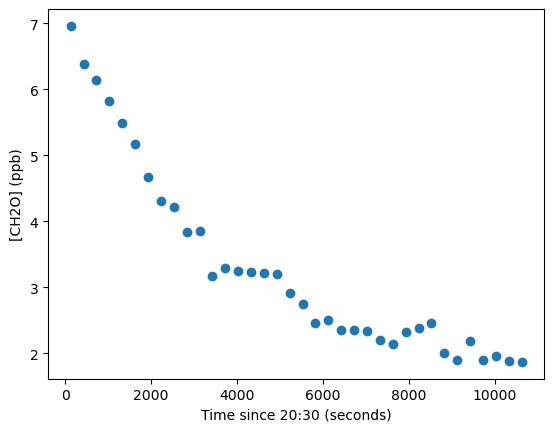

In [10]:


# Select a specific range of rows from the DataFrame
df_late = df.iloc[246:282]

# Define a function to calculate time delta from a given start time
def time_del(t):
    td = t - start
    return td

# Create an empty list to store time values
t_list = []


# Loop through the rows of df_late
for i in range(len(df_late)):
    
    # Calculate time by converting string to time and adding a timedelta
    time = string_to_time(df_late.iloc[i][0]) + dt.timedelta(hours=20, minutes=30)
    t_list.append(((time_del(time)).total_seconds()))
    
# Create a new DataFrame for time delta and CH2O concentration
df_conc_td = pd.DataFrame(columns=['Time_delta', 'CH2O_conc'], index=range(len(df_late)))

# Populate df_conc_td with time delta and CH2O concentration values
for i in range(len(df_late)):
    
    #check if conc=NaN, if not NaN then add it and time delta to new df
    if np.isnan(df_late.iloc[i][1]) == False:
        conc = df_late.iloc[i][1]
        df_conc_td.loc[i] = [t_list[i], conc]
        
    else: #if conc=NaN, interpolate as above
        
        #same procedure as in part 1: first check if conc in row above is NaN, if not use as first anchor point
        if np.isnan(df_late.iloc[i-1][1]) == False:
            
            #glean time and conc data from row above
            conc_last = df_late.iloc[i-1][1]
            time_last = t_list[i-1]
            
            #if conc in row below is not NaN, use as last anchor point
            if np.isnan(df_late.iloc[i+1][1]) == False:
                
                #glean time and conc data from row below
                conc_next = df_late.iloc[i+1][1]
                time_next = t_list[i+1]
                
                #get current time from time list (int of seconds since 20:30)
                time_now = t_list[i]
                
                #make array for first and last anchor points in x axis (time)
                arr1 = np.array([time_last,time_next])
                
                #make array for first and last anchor points in y axis (conc)
                arr2 = np.array([conc_last,conc_next])
                
                #interpolate using anchor arrays and current time
                conc = np.interp(time_now,arr1,arr2)
                
                #append estimated concentration to new df along with the associated time
                df_conc_td.loc[i] = [t_list[i], conc]
                
            else: #exact same as above but using conc 2 rows below because row below has NaN conc
                conc_next = df_late.iloc[i+2][1]
                time_next = t_list[i+1]
                time_now = t_list[i]
                arr1 = np.array([time_last,time_next])
                arr2 = np.array([conc_last,conc_next])
                conc = np.interp(time_now,arr1,arr2)
                df_conc_td.loc[i] = [t_list[i], conc]
                
        else: #exact same as above but using conc 2 rows above because row above has NaN conc
            conc_last = df_late.iloc[i-2][1]
            time_last = t_list[i-2]
            if np.isnan(df_late.iloc[i+1][1]) == False:
                conc_next = df_late.iloc[i+1][1]
                time_next = t_list[i+1]
                time_now = t_list[i]
                arr1 = np.array([time_last,time_next])
                arr2 = np.array([conc_last,conc_next])
                conc = np.interp(time_now,arr1,arr2)
                df_conc_td.loc[i] = [t_list[i], conc]
                
            else:
                conc_next = df_late.iloc[i+2][1]
                time_next = t_list[i+2]
                time_now = t_list[i]
                arr1 = np.array([time_last,time_next])
                arr2 = np.array([conc_last,conc_next])
                conc = np.interp(time_now,arr1,arr2)
                df_conc_td.loc[i] = [t_list[i], conc]


# Scatter plot of Time Delta vs. CH2O concentration
plt.scatter(df_conc_td.iloc[:, 0], df_conc_td.iloc[:, 1])
plt.xlabel('Time since 20:30 (seconds)')
plt.ylabel('[CH2O] (ppb)')
plt.show()

The rate constant, k, is 0.00012 s^-1.


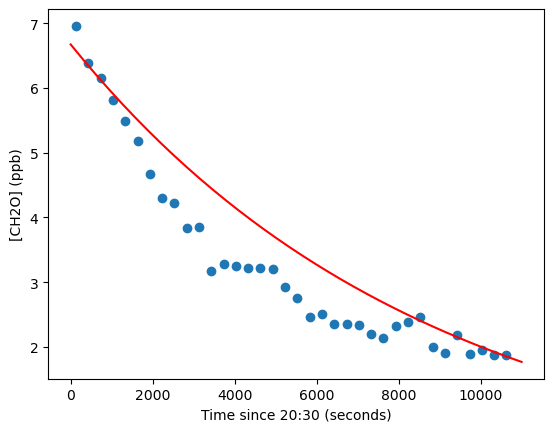

In [11]:
#assigning time to x array 
x = df_conc_td['Time_delta'].astype(str).astype(float)

#assigning initial CH2O conc
y_init = df_conc_td['CH2O_conc'][0]

#calculating ln(conc/initial_conc) and storing as array y
y = np.log(df_conc_td['CH2O_conc'].astype(str).astype(float)/y_init)

#linear regression to return slope and intercept: y (log(conc)) vs. x (time)
slope, intercept = np.polyfit(x,y, deg=1) 

print("The rate constant, k, is "+ str(-1*round(slope,5))+" s^-1.") #printing slope of regression line

#plotting results and regression line

#assigning y as an empty array of the size of x
y = np.zeros([len(x),1])

#iterating thru x and performing calculations to find expected conc
for i in range(len(x)):
    expo = np.exp(slope*x.iloc[i])
    #append expected conc to y
    y[i]=y_init*expo
    
#assign experimental concentrations to array z
z = df_conc_td['CH2O_conc']

#plot a scatterplot of experimental conc vs. time
plt.scatter(x,z)
x=np.linspace(0,11000,36) 

#plot a line of predicted conc vs. time
plt.plot(x,y+intercept,'red')

#set x and y labels and show
plt.xlabel('Time since 20:30 (seconds)')
plt.ylabel('[CH2O] (ppb)')
plt.show()